# Version 2: Advanced Evolutionary Programming (EP)
* Implement an advanced version of EP, including self-adaptive mutation
strategies, different selection mechanisms, or elitism.

In [17]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from statisticscalc import analyze_convergence, validate_and_plot

In [18]:
# Load data and set parameter values

# Load monthly returns data
monthly_returns_df = pd.read_csv('data/monthlyreturn/monthlyreturnstocks.csv')
monthly_returns_df = monthly_returns_df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Define parameters
population_size = 100    # Number of portfolios
num_generations = 1000   # Number of generations
mutation_rate = 0.1      # Base mutation probability
elitism_rate = 0.1  # 10% elitism
num_months = len(monthly_returns_df)  # Total months in the dataset
num_assets = monthly_returns_df.shape[1]  # Number of stocks/assets


# Advanced EP functions
* Here we have adde adaptive mutation rate but still globally. It changes the mutation rate based on the overall fitness of the portfolio

In [19]:
# Initialize population with each month allocated to 100% using dirichlet
# This applies a random allocation of weights between each month for the stocks. 
def initialize_population(size, num_months, num_assets):
    population = [np.array([np.random.dirichlet(np.ones(num_assets)) for _ in range(num_months)]) for _ in range(size)]
    population = np.array(population)
    print("Initialized population shape:", population.shape)  # Should be (100, num_months, num_assets)
    return population


# Adaptive mutation function
def adaptive_mutate(portfolio, base_mutation_rate, fitness, best_fitness, worst_fitness):
    """
    Takes in the portfolio, 
    asigns gaussian noise to the original portfolio, ensuring no negative numbers
    and ensures every month has exactly 1 assigned to all stocks
    Here it also changes the mutation rate based on fitness. If the fitness is high the
    mutation rate decreases. Applies opposite the other way
    """
    fitness_normalized = (fitness - worst_fitness) / (best_fitness - worst_fitness) if best_fitness != worst_fitness else 0.5
    mutation_rate = base_mutation_rate * (1 - fitness_normalized)
    
    mutated_portfolio = portfolio + np.random.normal(0, mutation_rate, size=portfolio.shape)
    mutated_portfolio = np.abs(mutated_portfolio)
    mutated_portfolio /= mutated_portfolio.sum(axis=1, keepdims=True)  # Normalize each month to sum to 1
    return mutated_portfolio

# Fitness function with cumulative compounding
def calculate_fitness(portfolio):

    """
    Calculates each months return and uses calcultes the return cumulatively for each month
    """
    monthly_returns = monthly_returns_df.to_numpy()
    cumulative_growth = 1.0  # Start with initial growth factor of 1 (100%)

    for month in range(num_months):
        month_weights = portfolio[month]
        month_return = np.dot(month_weights, monthly_returns[month])  # Weighted return for this month
        cumulative_growth *= (1 + month_return / 100)  # Compound the cumulative growth with this month's return

    cumulative_return = (cumulative_growth - 1) * 100  # Represent as percentage
    return cumulative_return

# Selection function with elitism
def select_best_with_elitism(population, fitness, num_to_select, elitism_rate):
    """
    Sorts the population vi argsort. Then picks a precentage based on elitism as the carry over
    to the new population
    """
    sorted_indices = np.argsort(fitness)[::-1]
    elite_count = int(len(fitness) * elitism_rate)
    elites = population[sorted_indices[:elite_count]]  # Top-performing individuals
    # This algorithm finds the best values and collects the 10% best to the new
    remaining_population = population[sorted_indices[elite_count:num_to_select]]
    return np.concatenate((elites, remaining_population))

# Advanced EP Version 2

In [20]:
# Main Evolutionary Programming loop
def Advanced_EP_V2(population_size, num_generations, mutation_rate, num_months, num_assets, elitism_rate):
    start_time = time.time()
    population = initialize_population(population_size, num_months, num_assets)
    generation_plot = []
    
    for generation in range(num_generations):
        fitness_scores = np.array([calculate_fitness(portfolio) for portfolio in population])
        best_fitness = np.max(fitness_scores)
        worst_fitness = np.min(fitness_scores)

        # Select top half with elitism
        population = select_best_with_elitism(population, fitness_scores, population_size // 2, elitism_rate)

        # Generate new population with adaptive mutations
        new_population = [adaptive_mutate(portfolio, mutation_rate, fitness, best_fitness, worst_fitness) 
                          for portfolio, fitness in zip(population, fitness_scores)]
        
        # Combine elites and new population
        population = np.array(population.tolist() + new_population)

        best_return = np.max(fitness_scores)
        generation_plot.append(best_return)
        
        if generation % 100 == 0:
            print(f"Generation {generation}: Best Cumulative Return = {best_return:.4f}")
            
    # Final optimized portfolio
    best_portfolio = population[np.argmax(fitness_scores)]
    end_time = time.time()- start_time
    return best_portfolio, generation_plot, best_return, end_time

Initialized population shape: (100, 59, 20)
Generation 0: Best Cumulative Return = 181.6139
Generation 100: Best Cumulative Return = 421.7836
Generation 200: Best Cumulative Return = 541.6351
Generation 300: Best Cumulative Return = 604.3432
Generation 400: Best Cumulative Return = 624.6738
Generation 500: Best Cumulative Return = 673.5495
Generation 600: Best Cumulative Return = 734.2726
Generation 700: Best Cumulative Return = 796.0821
Generation 800: Best Cumulative Return = 830.1238
Generation 900: Best Cumulative Return = 866.2982
Convergence achieved at generation: 388
Time to convergence: 6.83 seconds
Best Return: 939.6232369452757
Total Time: 17.59 seconds
All monthly allocations sum to 1.


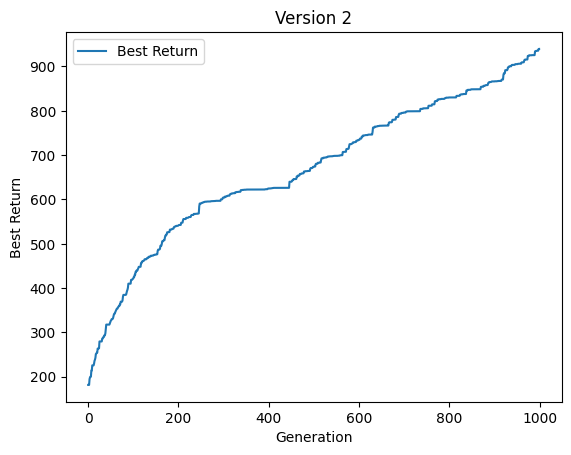

In [21]:
# Run the EP optimization
best_portfolio, generation_plot, best_return, end_time = Advanced_EP_V2(population_size, num_generations, mutation_rate, num_months, num_assets, elitism_rate)

analyze_convergence(generation_plot, end_time)
# Display final results
print("Best Return:", best_return)
print(f"Total Time: {end_time:.2f} seconds")
validate_and_plot(best_portfolio, generation_plot, num_months, title="Version 2", output_file="results/Version_2.png")
